<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Statements-and-pcmdpy-setup" data-toc-modified-id="Import-Statements-and-pcmdpy-setup-1">Import Statements and pcmdpy setup</a></span></li><li><span><a href="#Create-mock-pcmds-with-varying-Npix" data-toc-modified-id="Create-mock-pcmds-with-varying-Npix-2">Create mock pcmds with varying Npix</a></span><ul class="toc-item"><li><span><a href="#Baseline-Properties" data-toc-modified-id="Baseline-Properties-2.1">Baseline Properties</a></span></li><li><span><a href="#Model-1" data-toc-modified-id="Model-1-2.2">Model 1</a></span></li><li><span><a href="#Model-2" data-toc-modified-id="Model-2-2.3">Model 2</a></span></li><li><span><a href="#Model-3" data-toc-modified-id="Model-3-2.4">Model 3</a></span></li><li><span><a href="#Model-3" data-toc-modified-id="Model-3-2.5">Model 3</a></span></li></ul></li></ul></div>

# Import Statements and pcmdpy setup

In [2]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import seaborn as sns, pcmdpy as ppy, pandas as pd
%matplotlib inline

GPU acceleration not available, sorry
No module named 'pycuda'


In [3]:
d_mod = 24.47 # distance modulus to M31
d_mpc = 10.**((d_mod - 25.)/5.) # about 0.78
f = ppy.instrument.m31_filters(dist=d_mpc)

In [4]:
iso_model = ppy.isochrones.Isochrone_Model(f)
driv = ppy.driver.Driver(iso_model, gpu=False)

# Create mock pcmds with varying Npix

## Baseline Properties

In [82]:
N_im = 16

In [57]:
def draw_pcmd(basemodel, lognorm_sig, N_im, psf=True):
    imf, mags = iso_model.model_galaxy(basemodel)
    fluxes = np.array([filt.mag_to_counts(m) for filt,m in zip(f, mags)]).T
    N_bins = len(imf)
    frac_realized = np.random.lognormal(sigma=lognorm_sig, size=(N_im*N_im))
    en = np.outer(frac_realized, imf).reshape((N_im, N_im, N_bins))
    realized = np.random.poisson(en)
    ims = np.dot(realized, fluxes).T
    _, dust_mu, dust_sig = basemodel.dust_model.get_params()
    dust_screen = np.random.lognormal(mean=dust_mu, sigma=dust_sig, size=(N_im, N_im))
    reddening = np.array([10.**(-0.4 * dust_screen * filt.red_per_ebv) for filt in f])
    ims *= reddening
    if psf:
        ims = np.array([filt.psf_convolve(im) for filt,im in zip(f, ims)])
    mags = np.array([filt.counts_to_mag(im.flatten()) for filt,im in zip(f, ims)])
    
    return ppy.utils.make_pcmd(mags)

## Model 1

$[Fe/H] = -0.2$

$log E(B-V) = -0.5$

$Npix \sim \mathcal{N}(100, 10)$

$\tau = 1 Gyr$

In [64]:
gm = ppy.galaxy.DefaultTau
model_1 = gm.get_model(np.array([-0.2, -0.5, 2., 1.]))

In [65]:
pcmd_1 = draw_pcmd(model_1, 0.1, 256)

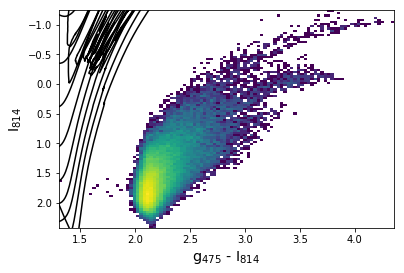

In [66]:
fig, axis = plt.subplots()
axis.hist2d(pcmd_1[1], pcmd_1[0], bins=100, norm=mpl.colors.LogNorm());
iso_model.plot_isochrone(model_1, axes=axis)

In [79]:
np.savetxt('../data/mockgrid_Npix_1.dat', pcmd_1[::-1,:].T, fmt='%.6f')

## Model 2

$[Fe/H] = -0.2$

$log E(B-V) = -0.5$

$Npix \sim \mathcal{N}(100, 10)$

$\tau = 2 Gyr$

In [84]:
gm = ppy.galaxy.DefaultTau
model_2 = gm.get_model(np.array([-0.2, -0.5, 2., 2.]))

In [85]:
pcmd_2 = draw_pcmd(model_2, 0.1, 256)

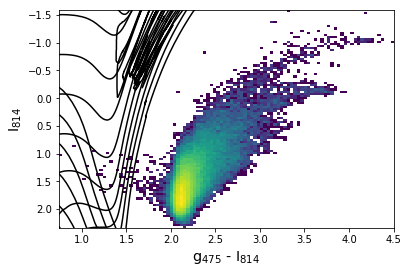

In [86]:
fig, axis = plt.subplots()
axis.hist2d(pcmd_2[1], pcmd_2[0], bins=100, norm=mpl.colors.LogNorm());
iso_model.plot_isochrone(model_2, axes=axis)

In [87]:
np.savetxt('../data/mockgrid_Npix_2.dat', pcmd_2[::-1,:].T, fmt='%.6f')

## Model 3

$[Fe/H] = -0.2$

$log E(B-V) = -0.5$

$Npix \sim \mathcal{N}(100, 10)$

Constant SFR

In [89]:
gm = ppy.galaxy.CustomGalaxy(ppy.metalmodels.SingleFeH, ppy.dustmodels.SingleDust, ppy.agemodels.ConstantSFR)
model_3 = gm.get_model(np.array([-0.2, -0.5, 2.]))

In [90]:
pcmd_3 = draw_pcmd(model_3, 0.1, 256)

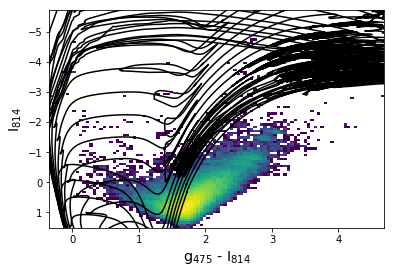

In [91]:
fig, axis = plt.subplots()
axis.hist2d(pcmd_3[1], pcmd_3[0], bins=100, norm=mpl.colors.LogNorm());
iso_model.plot_isochrone(model_3, axes=axis)

In [92]:
np.savetxt('../data/mockgrid_Npix_const.dat', pcmd_3[::-1,:].T, fmt='%.6f')

## Model 3

$[Fe/H] = -0.2$

$log E(B-V) = -0.5$

$Npix \sim \mathcal{N}(100, 10)$

Constant SFR

In [93]:
gm = ppy.galaxy.DefaultTau
model_4 = gm.get_model(np.array([-0.2, -0.5, 2., -1.]))

In [94]:
pcmd_4 = draw_pcmd(model_4, 0.1, 256)

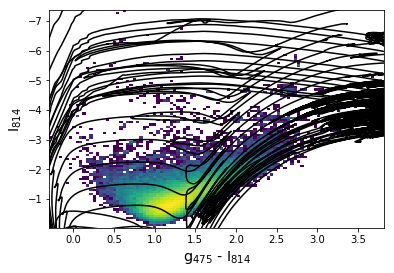

In [95]:
fig, axis = plt.subplots()
axis.hist2d(pcmd_4[1], pcmd_4[0], bins=100, norm=mpl.colors.LogNorm());
iso_model.plot_isochrone(model_4, axes=axis)

In [96]:
np.savetxt('../data/mockgrid_Npix_rising.dat', pcmd_4[::-1,:].T, fmt='%.6f')